In this step we generate monte-carlo samples for the clusters that are found by DBSCAN. This will allow us to calculate the errors of each cluster point later down the track. We calculate all the same values, including velocity and intergrals of motion.

In [2]:
#Load in relevant libraries
import math

import numpy as np

from astropy import units as u
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord, ICRS, Galactocentric, Distance, LSR
from astropy.coordinates import FK5
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.table import Table, vstack, hstack
from astropy.table import Column
from astropy.io import ascii

import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic

from scipy import stats

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler, normalize


import time

import matplotlib.pyplot as plt

import pandas as pd

In [3]:
#Load in the subset that contain the cluster data
t = Table.read('Step_3_Output.fits')

print("Total Number of Stars in Dataset: " + str(len(t)))

Total Number of Stars in Dataset: 6789


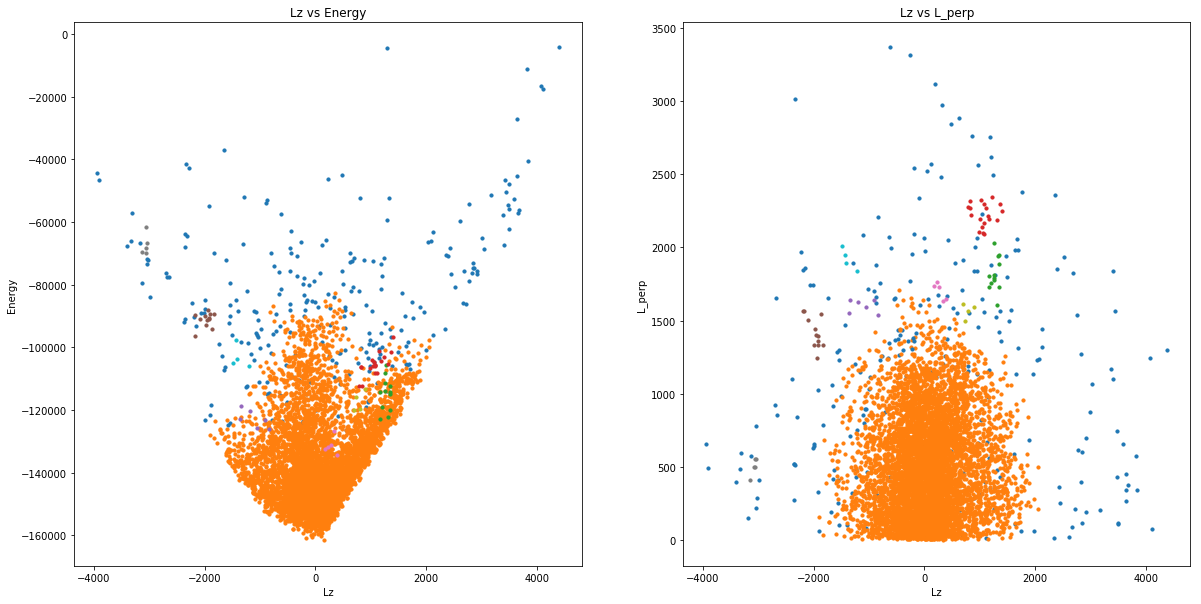

In [12]:
#Create plots of the Action Space to Show the potential clusters
# that need to be verified

#Set point size, this just sets the size of the points in the plot
size = 10

#This first plots the clusters in the action space of Lz and Energy
# the loop allows for each cluster value to be plotted as a different colour
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('Lz vs Energy')
plt.xlabel('Lz')
plt.ylabel('Energy')
for i in range(-1,16):
    table2=t[(t['cluster_label']==i) & (t['Energy']<0)]
    
    plt.scatter(table2['Lz'],table2['Energy'],s=size)

#pyplot.savefig('E1_Lz_vs_E_Cluster_Plot.png', dpi = 300, overwrite=True)

#This plost the Lz component to the perpendicular component of angular momentum
plt.subplot(122)
plt.title('Lz vs L_perp')
plt.xlabel('Lz')
plt.ylabel('L_perp')
for i in range(-1,16):
    table2=t[(t['cluster_label']==i)& (t['Energy']<0)]
    
    plt.scatter(table2['Lz'],table2['L_perp'],s=size)

#pyplot.savefig('E1_Lz_vs_Lperp_Cluster_Plot.png', dpi = 300, overwrite=True)

In [13]:
#To calucluate the errors on the clusters we remove the giant orange blob
# from the dataset
t_cluster = t[(t['cluster_label']>0)]
t_noise = t[(t['cluster_label']<0)]
t = vstack([t_cluster,t_noise])

print("Total Number of Stars in Dataset: " + str(len(t)))

Total Number of Stars in Dataset: 348


In [14]:
#We now run the Monte-Carlo to Estimate the Errors

#We first convert the astropy table to a pandas format as the code
# is written for such a dataset
star_list = t.to_pandas()

#We define the number of random samples for each star we want to draw
sample_size = 100

#We define a new table called Monte_Vals which will save the randomly sampled
# star values. 

Monte_Vals = Table()

#This is the Monte-Carlo algorythm, it produces a correlation matrix
# specified by Marchetti et al. 
for star_num,star in star_list.iterrows():

    tbl_names = ['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity']

    C = np.zeros((6, 6))

    for i,name in enumerate(tbl_names):

        err_name = "{0}_error".format(name)

        C[i,i] = (star[err_name]) ** 2

        for i,name1 in enumerate(tbl_names):

            for j,name2 in enumerate(tbl_names):

                if j <= i: # we make it symmetric below

                    continue

                full_name = "{0}_{1}_corr".format(name1, name2)

                if full_name not in star_list.columns:

                    continue

                C[i,j] = star[full_name] * np.sqrt(C[i,i]*C[j,j])

                C[j,i] = star[full_name] * np.sqrt(C[i,i]*C[j,j])

 

    y = np.array([star.ra, star.dec, star.parallax, star.pmra, star.pmdec, star.radial_velocity])

    #This line useses the numpy array and calculates the random sample based on the created
    # correlation matrix
    samples = np.random.multivariate_normal(y, C, size=sample_size)

 
    #The randomly generated sample are saved as coordinates in a similar manner as before
    coord_samples = coord.ICRS(ra=samples[:,0] * u.deg,

                               dec=samples[:,1] * u.deg,

                               distance=1000./samples[:,2] * u.pc,

                               pm_ra_cosdec=samples[:,3] * u.mas/u.yr,

                               pm_dec=samples[:,4] * u.mas/u.yr,

                               radial_velocity=samples[:,5] * u.km/u.s)
    
    #The coordinates are then calculated to Galactocentric coordinates
    galc = coord_samples.transform_to(Galactocentric)
    
    #All the values are then compiles into a table and added to the Monte_Vals Table
    # when complete.
    T = Table()
    
    STAR = Column(np.repeat(star['source_id'], sample_size),'source_id')
    T.add_column(STAR)
    
    RA = Column(coord_samples.ra, 'ra')
    DEC = Column(coord_samples.dec, 'dec')
    DIST = Column(coord_samples.distance, 'dist')
    PMRA = Column(coord_samples.pm_ra_cosdec, 'pmra')
    PMDEC = Column(coord_samples.pm_dec, 'pmdec')
    RV = Column(coord_samples.radial_velocity, 'radial_velocity')
    
    T.add_column(RA)
    T.add_column(DEC)
    T.add_column(DIST)
    T.add_column(PMRA)
    T.add_column(PMDEC)
    T.add_column(RV)
    
    x = galc.x
    y = galc.y
    z = galc.z

    x = Column(x,name='x_val')
    y = Column(y,name='y_val')
    z = Column(z,name='z_val')

    U = galc.v_x
    V = galc.v_y
    W = galc.v_z

    U = Column(U,name='U')
    V = Column(V,name='V')
    W = Column(W,name='W')
    
    T.add_column(x)
    T.add_column(y)
    T.add_column(z)

    T.add_column(U)
    T.add_column(V)
    T.add_column(W)
    
    Monte_Vals = vstack([Monte_Vals,T])
    #The Monte_Vals Periodically saves its process as this can take a long time
    # to complete if the sample size is high.
    Monte_Vals.write('Step_4_Monte_Carlo_Output.fits',overwrite=True)
    
    print("Completed Iterations: " + str(star_num) + " out of: " + str(len(star_list)), end="\r")

In [15]:
#The next lines of code generate the actions for all the Monte-Carlo Values
# in the same manner to what you did with the real values. Due to the large
#  volume you need to use a vectorised loop.

step = len(star_list)
ACT = Table()

for i in range(0,sample_size):
    
    #Taking the cartesian position and velocity coordinates from the table and saving them as vectors
    x = Monte_Vals['x_val'][step*i:step*(1+i)]
    y = Monte_Vals['y_val'][step*i:step*(1+i)]
    z = Monte_Vals['z_val'][step*i:step*(1+i)]
    U = Monte_Vals['U'][step*i:step*(1+i)]
    V = Monte_Vals['V'][step*i:step*(1+i)]
    W = Monte_Vals['W'][step*i:step*(1+i)]
    
    T = Table()

    #In order to calculate the actions, you need to specifiy a graviational potential. 
    # In this case we use a combination of potentials in the same manner as Helmi et al 2017. 
    #  Using the MilkyWayPotential class models the buldge, disk and halo in combination. 
    pot = gp.MilkyWayPotential(units=galactic)

    #We use the Gala function PhaseSpacePosition to save the 6-D phase space coordinates, which
    # are taken from the above vectors,
    w0 = gd.PhaseSpacePosition(pos=[x, y, z]*u.pc,
                           vel=[U, V, W]*u.km/u.s)
    #The orbit of the star is then calculated using the following command for 1000 steps
    orbit = gp.Hamiltonian(pot).integrate_orbit(w0, dt=1., n_steps=1000)
    
    #First Calculate the energies of each orbit# to the table
    E = orbit.energy().to(u.km*u.km/(u.s*u.s))
    Energy = Column(E[0], name = 'Energy')

    #Z-coomponent of angular momentum is calculated
    Lz = orbit.angular_momentum()[2].to(u.km*u.kpc/u.s)
    L_z = Column(Lz[0], name = 'Lz')
    

    #The x and y component of the angular momentum are caculated and then combined using 
    # pythagoras theorem
    Lx = orbit.angular_momentum()[0].to(u.km*u.kpc/u.s)
    Ly = orbit.angular_momentum()[1].to(u.km*u.kpc/u.s)

    #We calculcualte the perpedicular component of the angular momentum
    Lp = np.sqrt(Lx[0]*Lx[0]+Ly[0]*Ly[0])
    L_perp = Column(Lp, name = 'L_perp')

    T.add_column(Energy)
    L_z=-L_z
    T.add_column(L_z)
    T.add_column(L_perp)
    ACT = vstack([ACT,T])
    
    #Periodically save the actions after each loop
    ACT.write('Monte_Carlo_Action_Save_File.fits',overwrite=True)
    
    print("Completed Iterations: " + str(i) + " out of: " + str(1000), end="\r")

Monte_Vals = hstack([Monte_Vals,ACT])

#The Monte Carlo values with actions are saved as a new file 
Monte_Vals.write('Step_4_Monte_Carlo_Output.fits',overwrite=True)

#Also save the clusters without the monte-carlo values
t.write('Step_4_Output.fits',overwrite=True)

#Output the length of the Monte-Carlo file and your reduced data set
print("Total Number of Stars in Dataset: " + str(len(t)))
print("Total Number of Monte Carlo Stars: " + str(len(Monte_Vals)))

Total Number of Stars in Dataset: 348
Total Number of Monte Carlo Stars: 34800
